# Regular expressions (aka regexps)

The task is concentrated on using regular expressions for extracting basic information from textual data.
You will get more familiar with the regexp features that are particularly important in natural language processing.

## Task

A dataset containing texts of Polish statutory law is available at [http://apohllo.pl/text/ustawy.tar.gz](http://apohllo.pl/text/ustawy.tar.gz).

It contains texts of Polish bills, e.g.:

```
Tekst ustawy przyjęty przez Senat bez poprawek

USTAWA
z
dnia 8 listopada 2013 r.

o
zmianie niektórych ustaw w związku z realizacją ustawy budżetowej[1])

Art.
1.
W
ustawie z dnia 4 marca 1994 r. o zakładowym funduszu świadczeń socjalnych (Dz. U.
z 2012 r. poz. 592, z późn. zm.[2]))
po art. 5b dodaje się art. 5c w brzmieniu:
„Art. 5c. W 2014 r. przez
przeciętne wynagrodzenie miesięczne w gospodarce narodowej, o którym mowa w art.
5 ust. 2, należy rozumieć przeciętne wynagrodzenie miesięczne w gospodarce narodowej
w drugim półroczu 2010 r. ogłoszone przez Prezesa Głównego Urzędu Statystycznego
na podstawie art. 5 ust. 7.”.
```

Task objectives:

1. For each bill compute the number of the following amendments present in the bill:
   * addition of a unit (e.g. **dodaje się ust. 5a**),
   * removal of a unit (e.g. **w art. 10 ust. 1 pkt 8 skreśla się**),
   * change of a unit (e.g. **art. 5 otrzymuje brzmienie**).
2. Note that other types of changes, e.g. **po wyrazach "na dofinansowanie" dodaje się wyrazy " , z zastrzeżeniem art. 21a,"**, must not be included in the result.

In [1]:
import regex
import os
import pandas as pd

def find_in_files(reg, nazwa, wyniki):
    countAll = 0
    directory = '../ustawy/'
    fileList = os.listdir(os.getcwd() + '/' + directory)

    for filename in fileList:
        with open(os.path.join(directory + filename), 'r') as file:
            year, _ = filename.split('_')
            count = find_in_file(file, filename, reg)
            if count > 0:
                row = pd.DataFrame({'nazwa' : [nazwa], 'rok':[year], 'ilosc':[count]})
                wyniki = pd.concat([row, wyniki])
                # print('plik {}'.format(filename))
                # print(nazwa + ' {}\n'.format(count))
            countAll += count

    print("\nAll matches: {}\n".format(countAll))
    return countAll, wyniki


def find_in_file(file, filename, reg):
    infile = file.read()
    matches = regex.finditer(reg, infile, regex.MULTILINE | regex.IGNORECASE)
    count = 0
    for matchNum, match in enumerate(matches, start=1):
        count += 1
        # print("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum=matchNum,
        #                                                                     start=match.start(),
        #                                                                     end=match.end(),
        #                                                                     match=match.group()))

        # for groupNum in range(0, len(match.groups())):
        #     groupNum = groupNum + 1
        #
        #     print("Group {groupNum} found at {start}-{end}: {group}".format(groupNum=groupNum,
        #                                                                     start=match.start(groupNum),
        #                                                                     end=match.end(groupNum),
        #                                                                     group=match.group(groupNum)))
    return count

wyniki = pd.DataFrame({'rok' :[], 'nazwa' : [], 'ilosc' :[]})
units = r"((zdani[ea]|zd\.?)|(paragrafy?|par\.?|§)|(ustępy?|ust\.?)|(artykuły?|art\.?)|(rozdziały?|rozdz\.?)|(punkty?|pkt)|(podpunkty?|ppkt)|(liter[eęy]|lit\.?)|(tiret))"

nazwa = '"dodaje"'
reg = r"(dodaje)\W*(si[eę])?\W*" + units
print(nazwa)

countAll, wyniki, = find_in_files(reg, nazwa, wyniki)

nazwa = '"skreśla"'
reg = r"(skreśla)\W*(si[eę])?\W*" + units
print(nazwa)

countAll, wyniki, = find_in_files(reg, nazwa, wyniki)

nazwa = '"otrzymuje"'
reg = units + r"\W*[0-9]\W*i?\W*[0-9]?\W*?(otrzymuj[eą])\W*(brzmienie)"
print(nazwa)

countAll, wyniki = find_in_files(reg, nazwa, wyniki)

print(wyniki)

"dodaje"

All matches: 6514

"skreśla"

All matches: 1471

"otrzymuje"

All matches: 8587

          nazwa   rok  ilosc
0   "otrzymuje"  1996    5.0
0   "otrzymuje"  2003   55.0
0   "otrzymuje"  2000    5.0
0   "otrzymuje"  2003   52.0
0   "otrzymuje"  2004   22.0
..          ...   ...    ...
0      "dodaje"  1995    2.0
0      "dodaje"  1997    6.0
0      "dodaje"  2001    4.0
0      "dodaje"  2001    3.0
0      "dodaje"  2004    3.0

[1674 rows x 3 columns]


3. Plot results from point 1 showing how the percentage of amendments of a given type changed in the consecutive years.

In [2]:
s = wyniki.groupby(["rok", "nazwa"]).agg({'ilosc':'sum'})
s['percentage']= s['ilosc'] / s.groupby('rok')['ilosc'].sum() * 100

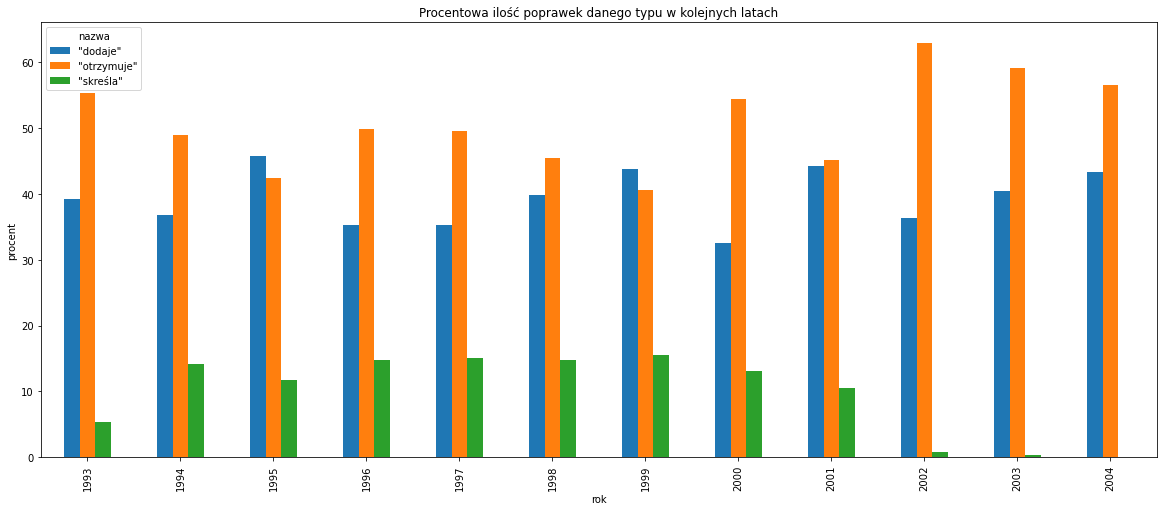

In [3]:
g = s.unstack().plot.bar(y='percentage')
g.set(ylabel='procent')
g.set_title("Procentowa ilość poprawek danego typu w kolejnych latach")
g.figure.set_size_inches(20,8)

> Niestety obserwujemy ciągły rozrost treści ustaw. Szczególnie w ostatnich latach analizowanego okresu bardzo mało jest skreśleń.

4. Compute the total number of occurrences of the word **ustawa** in any inflectional form (*ustawa*, *ustawie*, *ustawę*, etc.)
   and all spelling forms (*ustawa*, *Ustawa*, *USTAWA*), excluding other words with the same prefix (e.g. *ustawić*).

In [4]:
ustawa = r"(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustaw|ustawom|ustawami|ustawach)\b"

wyniki = wyniki.drop(wyniki.index, inplace=True)
nazwa4 = 'ustawa'
reg = ustawa
count_all_4, wyniki = find_in_files(reg, nazwa4, wyniki)


All matches: 24862



5. Compute the total number of occurrences of the same word (same conditions), followed by **z dnia** expression.

In [5]:
ustawa = r"(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustaw|ustawom|ustawami|ustawach)\b\W\W*\b(z\W*dnia)"

nazwa5 = 'ustawa z dnia'
reg = ustawa
count_all_5, wyniki = find_in_files(reg, nazwa5, wyniki)


All matches: 8578



6. As above, but **not** followed by **z dnia** expression. Is the result correct (result 4 =? result 5 + result 6)?

In [6]:
ustawa = r"(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustaw|ustawom|ustawami|ustawach)(\b\W\W*\b(?!(z\W*dnia))|\.|\,)"

nazwa6 = 'ustawa ! z dnia'
reg = ustawa
count_all_6, wyniki = find_in_files(reg, nazwa6, wyniki)

calc = count_all_5+count_all_6-count_all_4
if not calc:
    print("WYNIKI SIĘ ZGADZAJĄ!")
else:
    print("Wyniki różnią się o: {}".format(calc))


All matches: 16284

WYNIKI SIĘ ZGADZAJĄ!


7. Compute the total number of occurrences of the word **ustawa** in any inflectional form, excluding occurrences
   following **o zmianie** expression.

In [7]:
ustawa = r"(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustaw|ustawom|ustawami|ustawach)(\b\W\W*\b(?!(o\W*zmianie))|\.|\,)"

nazwa7 = 'ustawa ! o zmianie'
reg = ustawa
count_all_7, wyniki = find_in_files(reg, nazwa7, wyniki)


All matches: 24827



> Zwykle między "ustawa", a "o zmianie" występuje np.: z dnia, dlatego obserwujemy mało wyników "ustawa o zmianie"

8. Plot results 4-7 using a bar chart.

In [8]:
print(wyniki)

                 nazwa   rok  ilosc
0   ustawa ! o zmianie  1997      4
0   ustawa ! o zmianie  2000      4
0   ustawa ! o zmianie  1996      4
0   ustawa ! o zmianie  2001     11
0   ustawa ! o zmianie  2003    280
..                 ...   ...    ...
0               ustawa  2001     16
0               ustawa  1994      4
0               ustawa  2000     17
0               ustawa  2001      8
0               ustawa  2004     13

[4667 rows x 3 columns]


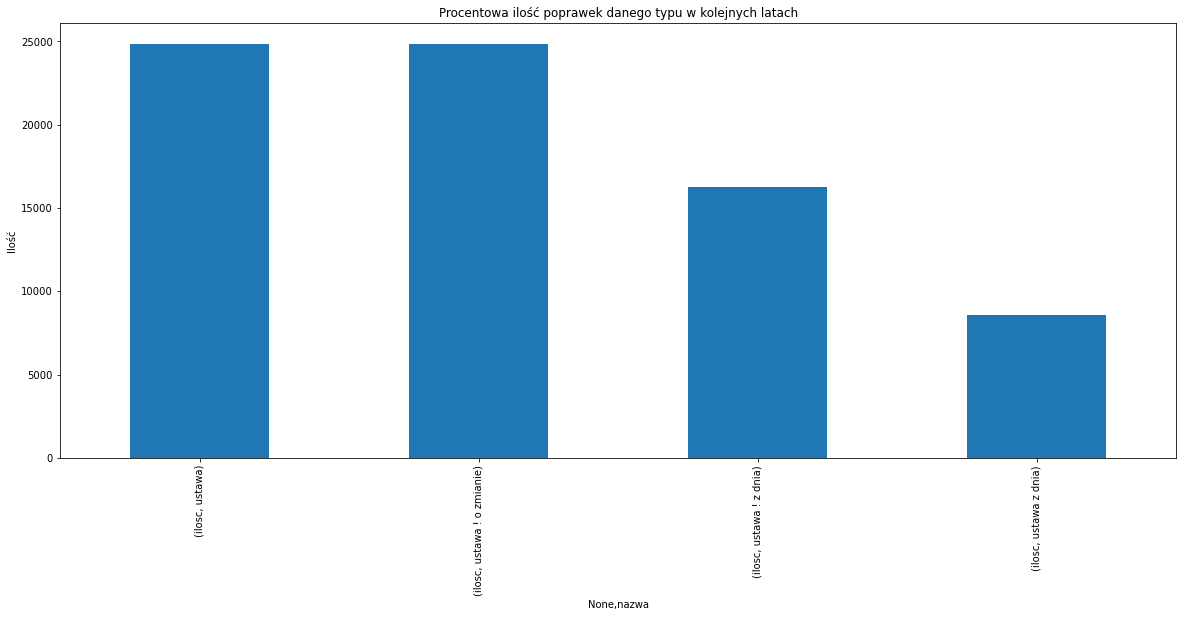

In [9]:
s = wyniki.groupby(["nazwa"]).agg({'ilosc':'sum'})

g = s.unstack().plot.bar(y='ilosc')
g.set(ylabel='Ilość')

g.set_title("Procentowa ilość poprawek danego typu w kolejnych latach")
g.figure.set_size_inches(20,8)

> Wyników "! o zmianie" jest prawie tak dużo jak dla "ustawa".
> Wyniki dla "ustawa z dnia" i "ustawa ! z dnia" sumują się.

## Hints

* Some programming languages allow to use Unicode classes in regular expressions, e.g.
  * `\p{L}` - letters from any alphabet (e.g. a, ą, ć, ü, カ)
  * `\p{Ll}` - small letters from any alphabet
  * `\p{Lu}` - capital letters from any alphabet
* Not all regular expressions engines support Unicode classes, e.g. `re` from Python does not.
  Yet you can use `regex` library (`pip install regex`), which has much more features.
* Regular expressions can include positive and negative lookahead and lookbehind constructions, e.g.
  * *positive lookahead* - `(\w+)(?= has a cat)` will match string `Ann has a cat`, but it will match `Ann` only.
  * *negative lookbehind* - `(?<!New )(York)`, will match `Yorkshire` but not `New York`.
* `\b` matches a word boarder. Regexp `fish` will match `jellyfish`, but `\bfish\b` will only match `fish`.
  In the case of Python you should use either `'\\bfish\\b'` or `r'\bfish\b'`.
* `\b` is dependent on what is understood by "word". For instance in Ruby polish diacritics are not treated as parts of
  a word, thus `\bpsu\b` will match both `psu` and `psuć`, since `ć` is a non-word letter in Ruby.
* Some languages, e.g. Ruby, support regexp match operator as well as regexp literals (`=~`, /fish/ respectively
  in the case of Ruby and Perl). Notably Python does not support either.
* You should be very careful when copying regexps from Internet - different languages and even different versions of the
  same language may interpret them differently, so make sure to always test them on a large set of diversified examples.